Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

## Lab 9: Classification

**This lab was distributed Monday 10/28/2019 and should be completed by Monday 11/4/2019 at 11:59PM.**

Welcome to lab 9, our **second-last** lab notebook of the semester!

This lab is on classification - essentially, how do we predict response variables that are qualitative (i.e. categorical) rather than quantitative?

Some real-life examples of classification, from ISLR, are:
1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?
1. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth.
1. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

We'll be exploring two methods to answer classification questions: logistic regression and k-nearest neighbours. In this week's homework, we'll explore a third method, decision trees. The textbook reference here is ISLR sections 4.1-4.3.

### Setup

In [2]:
# Run this cell
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

----

### Section 1: Logistic regression

Let's start with the simple example of a modelling problem where the categorical variable can take on two values. For example, take a look at example #2 above - a bank needs to determine whether a transaction is fraudulent, so it is trying to model a situation with two potential values of the response variable: either the transaction was fraudulent (we'll give this category a value of Y = 1) or it was not (we'll give this category a value of Y = 0).

Since Y isn't a *continuous* variable - it can only take on a value of 0 or a value of 1, and these values don't represent any particular ordering - we use logistic regression, which models the *probability* that Y = 0 or Y = 1. We can write this probability as:

$ Pr(Y = 1|X)$ 

The expression above, in words, means "the probability that Y = 1 given X". In our case, Y = 1 means the transaction was fradulent, and X is the matrix of predictor variables (transaction history, IP address, etc) that we're using to predict Y. This probability expression can be written using the following shorthand:

$ Pr(Y = 1|X) = p(X)$ 

We *could* model this probability using a simple linear regression model, that would look something like this:

$p(X) = \beta_0 + \beta_1X_1$

As we'll see throughout the lab, however, simple linear regression doesn't really give us meaningful results when it comes to classification problems. Instead, logistic regression proposes a model that looks like this, called the logistic function:

$p(X) = \frac{e^{\beta_0 + \beta_1X_1}}{1 + e^{\beta_0 + \beta_1X_1}}$

The two model forms above (linear and logistic regression) show the model form when we have one feature $X_1$, but can be easily extended to multiple features. The key to the logistic function is that it can only evaluate to values between 0 and 1, so it will always represent a probability.

Another important and related parameter is the **odds**. In statistics, the odds are defined as the probability of success over the probability of failure. If something is 50% likely to succeed, then its odds are 1 - there is an equal probability of success to failure. If it's 80% likely to succed, its odds are 0.8/(1-0.8) = 4 - there is a 4 to 1 chance of success to failure. The odds of $p(X)$ can be written as:

$\frac{p(X)}{1-p(X)}$

The odds of $p(X)$ can take any value between 0 and infinity. The logistic function can be re-written in the following way:

$log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X_1$

This should look super familiar! It looks *almost* like a linear regression. Basically, we can represent the log-odds (also called the logit) as a function that is linear in $X_1$. It's important to be careful with interpretation here, though - even though the relationship between the logit and $X$ is linear, the relationship between $p(X)$ and $X$ is not. A unit increase in $X_1$ in the formula above represents an increase equal to $\beta_1$ in the *log-odds* of $p(X)$, which is the same as multiplying the odds by $e^{\beta_1}$. The amount that $p(X)$ changes when $X$ changes depends on the current value of $X$. However, there is a simple interpretation to the signs of the coefficients - if $\beta_1$ is positive, that means that an increase in $X_1$ leads to an increased probability of $p(X)$.

The basic intuition for how to choose the $\beta$ coefficients for logistic regression is similar to linear regression. With linear regression, we want to choose coefficients that make the prediction as close as possible to the observation $y$. With logistic regression, we want to choose coefficients that make the predicted probability (of, for example, a fraudulent transaction) as close as possible to the actual category of the transaction (1 for a fraudulent transaction, 0 for a non-fraudulent transaction). Logistic regression software functions work by maximizing something called the likelihood function, much like linear regression functions work by minimizing the mean squared error.

**Warm-up:** In the explanation above, we asserted that:

$log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X_1$

Using a little bit of algebra, prove the claim above - that the logistic function representation is equivalent to logit representation for the logistic regression model. i.e. you should start with the logistic function:

$p(X) = \beta_0 + \beta_1X_1$

and solve for

$log\left(\frac{p(X)}{1-p(X)}\right)$

to get the logit representation above.

*Your answer here (either in markdown or as an embedded image)*

**Solution**: We know from 4.2 that the logistic function 

$$p(X) = \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}$$

Put in the form: 
$$\frac{p(X)}{1-p(X)}$$ 

$$= \frac{\frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}}{1 - \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}}$$ 

$$= \frac{\frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}}{\frac{1+e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}} - \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}}$$ 

$$= \frac{\frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}}{\frac{1}{1+e^{\beta_0 + \beta_1X}}}$$ 

And we prove that the logistic function representation is equivalent to logit representation for the logistic regression model 
$$\frac{p(X)}{1-p(X)} = e^{\beta_0 + \beta_1X}$$ 

Now that we've gone through the basics, we can load our data and try implementing logistic regression.

In this section, we'll work with a modified version of the [ozone level detection dataset](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection) from the UCI Machine Learning Repository, which uses temperature, wind speed, pressure, and other features to decide if a specific day was in fact a normal day or a high ground level ozone day. 

Run the cell below to load ozone.csv into dataframe `df`.

In [3]:
# run this cell
df = pd.read_csv('data/ozone.csv')
df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Class,intercept
0,4/30/1998,0.0,0.6,0.2,0.3,0.6,1.0,1.3,1.9,1.3,...,17.14,5.87,5745,16.40,43.50,10145,-10,0.0,1.0,1.0
1,5/12/1998,0.8,0.4,0.3,1.4,2.4,2.1,2.7,2.7,4.0,...,20.14,-4.56,5830,8.30,37.80,10095,-15,0.0,0.0,1.0
2,5/18/1998,0.0,0.2,0.0,0.5,0.1,0.4,0.5,0.6,1.3,...,5.38,-2.80,5935,5.70,36.40,10190,-10,0.0,1.0,1.0
3,5/29/1998,1.5,1.3,0.8,0.9,0.9,1.0,1.1,2.5,2.2,...,3.57,-2.00,5890,22.95,49.35,10140,5,0.0,1.0,1.0
4,8/1/1998,0.9,1.1,0.8,1.4,0.8,0.7,2.0,2.9,2.2,...,-4.96,-1.06,5965,23.20,42.40,10180,5,0.0,1.0,1.0


Looking at the columns, we can infer that columns WSR0, WSR1, etc. are the hourly measurements for the wind speed, and the last columns, `Class`, is the variable we want to predict. 0 is a  normal day and 1 is an ozone day. If you want more information on the features, you can read up on the description of the data [here](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection). 

**Question 1.1** Plot `Class` against `WSR_PK`. 

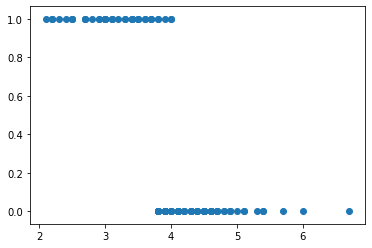

In [5]:
# barebones solution
plt.scatter(df.WSR_PK, df.Class);

**Question 1.2** Run the cell below to fit a linear regression to the data shown above. Based on the plot and your understanding of the data, why would linear regression be a poor choice for a predictive model in this case?

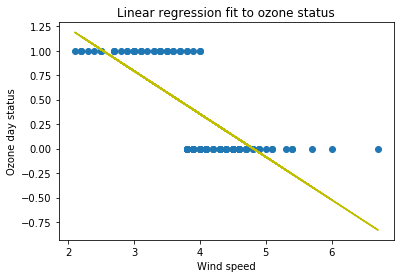

In [6]:
# run this cell
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(df[["WSR_PK"]], df[["Class"]])

plt.scatter(df.WSR_PK, df.Class)
plt.plot(df.WSR_PK, lm.predict(df[["WSR_PK"]]), c = "y")
plt.xlabel("Wind speed")
plt.ylabel("Ozone day status")
plt.title("Linear regression fit to ozone status");

*Your answer here*

----
Let's try building a predictive model! First, let's try doing logistic regression with statsmodels. We'll use the [`Logit()` function](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html) function.

As an aside: we could also use scikit-learn's `LogisticRegression()` function, but scikit-learn performs logistic regression using a penalty by default, while statsmodel uses maximum likelihood estimation to choose coefficients. Both are useful depending on how you want to solve for your coefficients!

**Question 1.3** Run a logistic regression on the ozone dataset, using "Class" as the response variable and `WSR_PK` as the predictor. The code below gets you started. You may remember that statsmodels models require the `X` input to contain a column of ones to represent the intercept. Conveniently, the last column of our dataframe `df` is a column of ones called `intercept`! (Otherwise, you can use `np.ones()` to create a column of ones). Using the code below as a starting point, run a logistic regression that predicts `Class` given `WSR_PK` and `intercept`, and then print the parameters.

If you can't remember how to fit models with statsmodels, look back at Question 3.5 in HW5.

In [8]:
# solution
import statsmodels.api as sm

y = df.Class
X = df[['WSR_PK', 'intercept']]

logit = sm.Logit(y, X)
s = logit.fit()
s.params

Optimization terminated successfully.
         Current function value: 0.145107
         Iterations 10


/srv/app/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


WSR_PK      -11.711721
intercept    44.271185
dtype: float64

Let's use these weights (i.e. parameters or coefficients) shown above to plot predicted probabilities. To do that, we have to be able to calculate probability from the weights. Recall the relationship:
$$p(X) = \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}$$

**Question 1.4** Write a function `prob_logit()` that returns a vector of probabilities p(X) given a vector of $\beta$ values and a matrix of $X$ values. The function `np.exp()` will be helpful here.

In [10]:
def prob_logit(params, X):
    """
    This function calculates the probability p(X) given a set of weights (params) and a matrix of X values.
    Arguments:
    params, a vector of weights from a logistic regression fit
    X, a matrix of predictor values with a number of columns equal to number of elements in params
    
    Returns:
    p, a vector of probabilities with the same length as the number of rows in X
    """
    
    x_weight = 0
    for param, col in zip(params, range(X.shape[1])):
        x_weight = x_weight + param*X.iloc[:,col]
    p = np.exp(x_weight)/(1+np.exp(x_weight))
    return p.values

In [11]:
# check dimensions of output vector
assert(len(prob_logit(s.params, X)) == X.shape[0])

**Question 1.5** The `assert` block above checked the dimensions of your output. In the cell below, check that all the values in your output vector `p` are between 0 and 1 (inclusive) - i.e. we want to make sure that we're calculated a probability! If you find that your values are not all greater than or equal to 0 and less than or equal to 1, double check the calculation in `prob_logit()`.

In [13]:
# potential solution
p = prob_logit(s.params, X)
print((p >= 0).all())
print((p <= 1).all())

True
True


**Question 1.6** Now that we have our probabilities, we can plot our predictor variable (`WSR_PK`) vs our response variable (`CLASS`) with a curve representing the probability of an ozone day at each value of `WSR_PK` overlayed. Create that plot below - you will end up with a plot that looks like the one in 1.1, with a curve overlayed.

Note that to avoid a plot where `matplotlib` just connects the dots and you have lines all over the place, you'll have to pass a *sorted* version of `WSR_PK` to your function `prob_logit()`. Below, we've defined a variable `X_plot` that sorts the `WSR_PK` values that you can use as an input (assuming that you wrote `prob_logit()` to take a matrix `X` as input that contains features and the intercept; if you wrote `prob_logit()` to take a matrix without an intercept, you'll have to modify `X_plot`).

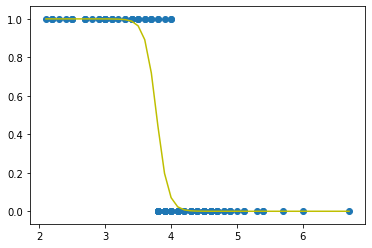

In [15]:
# SOLUTION
X_plot = df[['WSR_PK', 'intercept']].sort_values(by = 'WSR_PK')
plt.scatter(df.WSR_PK, df.Class);
plt.plot(X_plot['WSR_PK'], prob_logit(s.params, X_plot), c = 'y')

**Question 1.7** Visually, at what values of `WSR_PK` is our model pretty accurate? At what values of `WSR_PK` does it lose accuracy?

Although we used only one feature for our regression, logistic regression also works with multiple features and is a powerful tool for classification. Also - everything else we've learned, including train/test splits, cross validation, and regularization, are relevant and useful in the context of logistic regression, although we are not applying them in this lab.

Next up, we'll review k-nearest neighbors.

----

### Section 2: A Review of  k-Nearest Neighbors

In homework 5, we used the KNN algortithm for regression -- to predict the PM2.5 levels based on the average of the surrounding k measurements. But this time around, we'll use the ozone dataset again and use KNN to classify the normal or ozone days. This time around, we'll be working with two features, namely the peak wind speed (`WSR_PK`) and the peak temperature (`T_PK`), instead of just one feature.

Run the following cell to a see a scatter plot of the data.

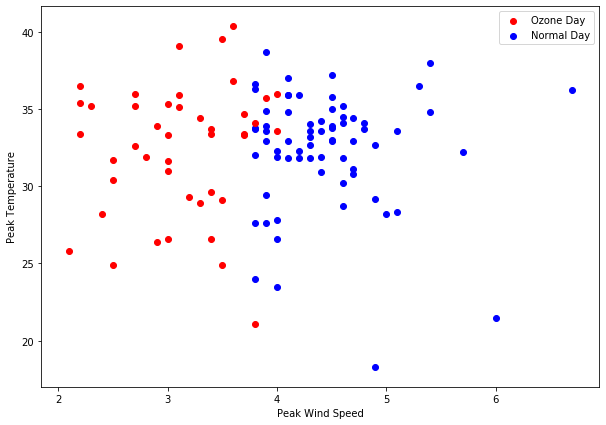

In [16]:
plt.figure(figsize=(10, 7))
plt.ylabel('Peak Temperature')
plt.xlabel('Peak Wind Speed')
for i in range(df.shape[0]):
    if df.Class[i] == 0: # if it's a normal day.
        pltcolor = 'b'
    else:
        pltcolor = 'r'
    plt.scatter(df.WSR_PK[i], df.T_PK[i], c=pltcolor)
plt.legend(['Ozone Day', 'Normal Day']);

Using KNN doesn't seem like a bad idea -- there's only a few cross overs and the possible decision boundary doesn't look too messy. 

Instead of coding the KNN algorithm from scratch like we did in homework 5, we'll make use of scikit-learn's `KNeighborsClassifier`. Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to see if there are any arguments you could tweak.

**Question 2.1** Split the data into training and tests sets using `train_test_split`, with `test_size = 0.25` and `random_state = 1`. Then, instantiate a scikit-learn KNN model and fit the model with `WSR_PK` and `T_PK`. First set n_neighbors to 4, and then choose a value for peak wind speed and peak temperature and use `.predict()` to determine the ozone class at those values. Is the class what you expect it to be?

In [18]:
# SOLUTION
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['WSR_PK', 'T_PK']], df.Class, 
                                                    test_size = 0.25, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

knn.predict([[3, 30]]) #should be an ozone day (1)

array([1.])

**Question 2.2** In a couple sentences, explain in your own words how KNN works for classification problems. You can use formulas if it helps you explain or understand the method. How does KNN decide if a given wind speed and temperature corresponds to an ozone day?

**Answer**: KNN determines the K (K >= 1) points that are closest to the point at which we want to predict a value, and then calculates the expected value of each class within those K points. It will assign the class of the prediction point to be equal to the class with a higher expected value. In our case, for a given point, KNN looks for the K nearest values (using a Euclidean distance, or the square root of the sum of the difference between wind speeds squared and the difference between temperatures squared). It then figure out what fraction of those K points are an ozone day, and what fraction are not an ozone day, and then assigns the class based on the larger fraction.

---

Now that we have our classifier fitted, let's test out some values of K. Before we do so, run the cell below, which defines a function that plots the decision boundary for a classifier when given a number of neighbors.

In [19]:
def plot_boundary(model, X, y, n_neighbors):
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_bold = ListedColormap(['#0000FF', '#FF0000'])
    h = .02
    
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Peak Wind Speed')
    plt.ylabel('Peak Temperature')
    plt.title("Ozone/Normal Day Classification (k = %i)"
              % (n_neighbors))
    
    plt.show()

**Question 2.3** Plot three decision boundaries, using a small value for K, a large value for K, and one somewhere in between. Use `.fit()` to train the model on the training data, use `plot_boundary()` to produce a plot, and use `.score()` to get the score of the model on the test data - i.e. the mean accuracy, or the proportion of test data points that were accurately classified. Make sure to show the plot and the score for each value of K.

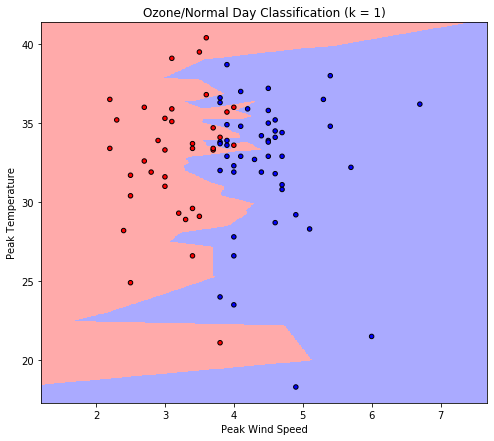

0.9285714285714286


In [20]:
# ex1
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(X_train, y_train)
plot_boundary(knn1, X_train, y_train, 1)
print(knn1.score(X_test, y_test))

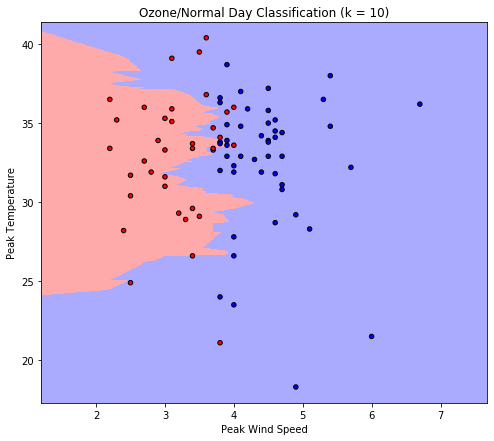

0.8928571428571429


In [21]:
# ex2
knn10 = KNeighborsClassifier(n_neighbors = 10)
knn10.fit(X_train, y_train)
plot_boundary(knn10, X_train, y_train, 10)
print(knn10.score(X_test, y_test))

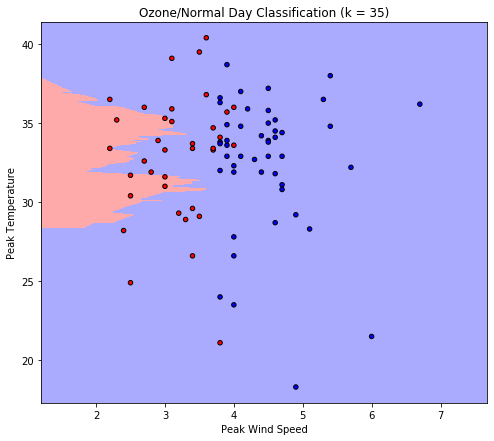

0.8214285714285714


In [22]:
# ex3
knn35 = KNeighborsClassifier(n_neighbors = 35)
knn35.fit(X_train, y_train)
plot_boundary(knn35, X_train, y_train, 35)
print(knn35.score(X_test, y_test))

**Question 2.4** Now that we have a a few plots of various decision boundaries, what are some problems with using small or large values for K? Reference your plots in your answer.

**Answer** Small values of K leads to a very flexible model, that possibly picks up patterns that are characteristic of the training dataset only (it leads to high variance). In our case it seems like K = 1 actually performs pretty well, but in other cases it may lead to poor performance on the test data.

Large values of K mean that we're considering a lot of points in our expected value, some of which don't actually have a bearing on our point of interest. We can see that in the plot with K = 35, which underestimates the extent of the variable space that should be classified as an ozone day. A large K leads to an inflexible model, with more bias.